## Lorenz System and Chaos

The Lorenz system of coupled, ordinary, first-order differential equations have chaotic solutions for certain parameter values $σ$, $ρ$ and $β$ and initial conditions, $u(0)$, $v(0)$ and $w(0)$. The Lorenz equations (published in 1963 by Edward N. Lorenz a meteorologist and mathematician) are derived to model some of the unpredictable behavior of weather. 

$$
 \begin{gather} \tag{1}
    \begin{aligned}
        \frac{du}{dt} = σ(v-u) \\
        \frac{dv}{dt} = ρu−v−uw \\
        \frac{dv}{dt} = uv−βw
    \end{aligned}
\end{gather}
$$


In [152]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# https://scipython.com/blog/the-lorenz-attractor/
def create_lorenz_attractor_dataset(tmax, dt):

    # Dynamics of The Model
    def lorenz(t, X, sigma, beta, rho):
        """The Lorenz equations."""
        u, v, w = X
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return up, vp, wp

    # Lorenz paramters and initial conditions.
    sigma, beta, rho = 10, 8./3, 28
    u0, v0, w0 = 1, 1, 1

    # Integrate the Lorenz equations.
    soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho), dense_output=True)

    # Interpolate solution onto the time grid, t.
    t = np.linspace(0, tmax, dt)
    Z = soln.sol(t)

    return t, Z

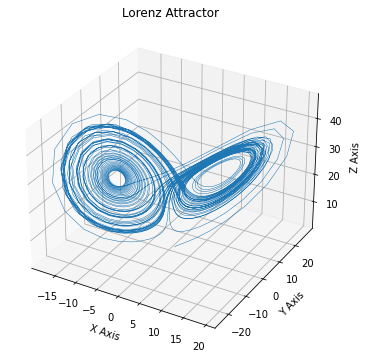

In [153]:
def show_lorenz_attractor(Z):
    ax = plt.figure(figsize=(12,6)).add_subplot(projection='3d')
    ax.plot(Z[0], Z[1], Z[2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")
    plt.show()

tmax = 60
dt = 2000

# Create Chaos dataset
t, Z = create_lorenz_attractor_dataset(tmax, dt)
show_lorenz_attractor(Z)

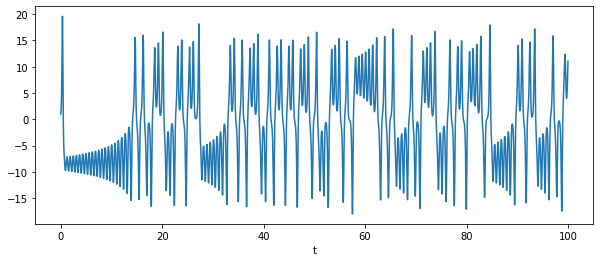

In [154]:
def show_lorenz_attractor_X(dt, X):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(dt, X, linestyle='solid')
    ax.set_xlabel("t")
    plt.show()
    
tmax = 100
dt = 10000

t, Z = create_lorenz_attractor_dataset(tmax, dt)
show_lorenz_attractor_X(t, Z[0])

## Forecasting Chaotic Time-Series via Recurrent Neural Networks (RNNs)

In [155]:
import random
import torch
from torch import nn

class RNNLayer(nn.Module):
    """RNN Layer

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        # Loop through time
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.do = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Default mode is teacher forcing
        self.teacher_forcing_ratio = 0.0

    def forward(self, x, hidden=None):
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        if use_teacher_forcing:
            rnn_output, _ = self.rnn(x)
            rnn_output = self.do(rnn_output)
            out = self.fc(rnn_output)
            return out, rnn_output
        else:
            # If hidden activity is not provided, initialize it
            if hidden is None:
                hidden = self.rnn.init_hidden(input.shape).to(input.device)

            rnn_output = []
            x_t = input[0]
            # Loop through time
            for i in range(input.size(0)):
                hidden = self.rnn.recurrence(x_t, hidden)
                hidden = self.do(hidden)
                x_t = self.fc(hidden)
                rnn_output.append(hidden)
            # Stack together output from all time steps
            output = torch.stack(rnn_output, dim=0)  # (seq_len, batch, hidden_size)
            rnn_output = self.do(rnn_output)
            out = self.fc(output)
            return out, rnn_output


## Define the Dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Discard % of Data
split_ratio = 0.5
split_index = int(split_ratio * len(t))
t = t[split_index:]
X = Z[0][split_index:]

# Normalize the Data
normalize_data = False
if normalize_data:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)

# The input to the RNN is a time-delay-embedded matrix of X(t) with embedding dimension q (also known as lookback; Kim et al., 1999).
q = 10
X_train = np.expand_dims(X, axis=1)
X_train_step = np.zeros((q, len(t)-q, 1))
for s in range(len(X)-q):
    for step in range(q-1, -1, -1):
        X_train_step[step, s, :] = X_train[s+q-step-1, :]
Y_train = X[q:]

# X has the form nsteps x samples x input_dim
# Y has the form samples x input_dim
X_train_step = torch.from_numpy(X_train_step).type(torch.float)
X_train_step_ss = torch.clone(X_train_step)
Y_train = torch.from_numpy(Y_train).type(torch.float)

## Train the Recurrent Neural Network (RNN) via Teacher-forcing

Teacher forcing is a technique that is frequently used in dynamical supervised learning tasks where the model (student) receives the ground truth output $d(t)$ (teacher) in the subsequent computation of the behaviour of the network. In our context, this framework allows us to design tasks that we understand perfectly, and since the teacher and student are both neural networks with the same activation function, we also know that the student is, in principle, capable of imitating the teacher flawlessly.

In [ ]:
# Set flags
sgd = True
adam = False

In [ ]:
# Init RNN model
hidden_dim = 200
net = RNNNet(1, hidden_dim, 1)

if sgd:
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
if adam:
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_func = nn.MSELoss()

# Number of iterations treated as burn-in
burn_in_period = 100

for epoch in range(2000):
    # Reset State and Burn-in
    net(X_train_step[:,0:burn_in_period,:])

    optimizer.zero_grad()
    input = X_train_step[:,burn_in_period:,:]
    pred, _ = net(input)

    loss = loss_func(pred[q-1,:,0], Y_train[burn_in_period:])
    loss.backward()
    optimizer.step()

    if epoch%20==0:
        print(epoch, loss.data.item())

0 56.71111297607422
20 19.33933448791504
40 11.873859405517578
60 7.728290557861328
80 5.556124210357666
100 4.632594108581543
120 3.6446056365966797
140 3.5176610946655273
160 2.954984664916992
180 2.5069053173065186
200 2.8027305603027344
220 2.123150587081909
240 1.9497804641723633
260 2.132289171218872
280 1.945786952972412
300 1.7008755207061768
320 1.8629322052001953
340 1.5912578105926514
360 1.5732214450836182
380 1.582163691520691
400 1.411060094833374
420 1.7813266515731812
440 1.2498918771743774
460 1.1058056354522705
480 1.099849820137024
500 1.0738091468811035
520 1.0770453214645386
540 1.1767563819885254
560 1.049946665763855
580 0.9593597054481506
600 1.034507393836975
620 0.877690315246582
640 0.7954707741737366
660 0.767288863658905
680 0.7632116079330444
700 0.8314054012298584
720 0.7939456105232239
740 0.7136925458908081
760 0.7115510702133179
780 0.7198845744132996
800 0.6628799438476562
820 0.6584345102310181
840 0.6423413157463074
860 0.6217926144599915
880 0.5849

In [ ]:
def plot_time_series(true, pred, normalize_data, label):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    if normalize_data:
        true = scaler.inverse_transform(true)
        pred = scaler.inverse_transform(pred)
    ax.plot(true, label="True")
    ax.plot(pred, label="Pred")
    ax.set_xlabel("t")
    ax.legend(loc=1)
    ax.set_title(label)
    plt.show()

## Generate the Recurrent Neural Network (RNN) Predictions at Training Points

0.2928695


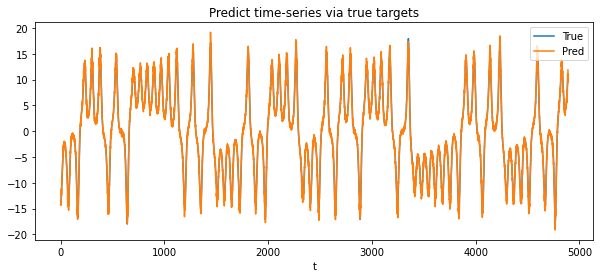

In [ ]:
# Reset State and Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Predict time-series via true targets
pred, _ = net(X_train_step[:,burn_in_period:,:])

# Compute loss
error = loss_func(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), normalize_data, "Predict time-series via true targets")

## Forecasting the time-series with a seed input

87.533615


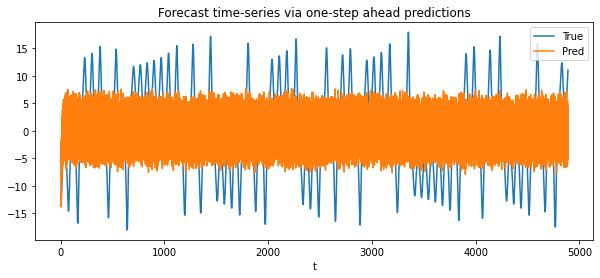

In [ ]:
def one_step_ahead(net, data, n_predictions):
    """
    Generally, time series forecasting describes predicting the observation at the next time step. This is called a one-step forecast.
    The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
    """
    pred = []
    for _ in range(n_predictions):
        y_t, _ = net.forward(data)
        data[0:q-1,:,:] = data[1:q,:,:].clone()
        data[q-1,:,:] = y_t[q-1,:,:]
        pred.append(data.detach().numpy()[-1,0,0])
    return pred

# Reset State and Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Forecast time-series via one-step ahead predictions
data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
one_step = one_step_ahead(net, data, X_train_step[:,burn_in_period:,:].shape[1])
one_step = np.asarray(one_step)

# Compute loss
error = loss_func(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], one_step, normalize_data, "Forecast time-series via one-step ahead predictions")

## Linear Analysis of the RNN

### "Linearize around the fixed point by taking the eigenvalues of the Jacobian"

Given a nonlinear ODE system,

$$
 \begin{gather} \tag{2}
    \begin{aligned}
        \frac{dx(t)}{dt} = f(x(t),p,t)
    \end{aligned}
\end{gather}
$$

We convert can convert to linear ODE system by linearizing around the operating point via the Taylor Expansion. It explains the dynamical behaviour of a function $f(x)$ that is infinitely differentiable at $a$ as a power series.

$$
 \begin{gather} \tag{3}
    \begin{aligned}
        f(x) &= f(a) + f'(a)(x-a) + \frac{f''(a)(x-a)^2}{2!} + ... + \frac{f^{(k)}(a)(x-a)^k}{k!} \\
        f(x^{SS} + \eta)  &= f(x^{SS}) + \eta f'(x^{SS}) + O(\eta^2) \\
        \dot{\eta} &\approx \eta f'(x^{SS}) \\
        \text{where if} \\
        &   f(x^{SS}) > 0, \text{increases exponentially (unstable)} \\
        &   f(x^{SS}) < 0, \text{decreases exponentially (stable)}
    \end{aligned}
\end{gather}
$$

For a linear homogeneous system of ODEs, the linear algebra view 
$$
 \begin{gather} \tag{4}
    \begin{aligned}
        \frac{dx(t)}{dt} = Ax \text{, where A represents the System Matrix} \\
    \end{aligned}
\end{gather}
$$

with solutions of the form,

$$
 \begin{gather} \tag{5}
    \begin{aligned}
        x(t) = \Sigma \alpha_i v_i e^{\lambda_i t}
    \end{aligned}
\end{gather}
$$

Plug into $\dot{x} = Ax$ and we get $Av = \lambda v$ This implies that the eigenvectors of the system matrix give the directions of straight-line trajectories with the eigenvalues as a scaling factor for exponential growth or decay. P.S - Complex eigenvalues indicate oscillations.

### Jacobian of a 1-Layer Neural Network

Suppose we have a function $f : R^n → R^m$ that maps a vector of length $n$ to a vector of length 
$$
m: f(x) = [f1(x1, ..., xn), f2(x1, ..., xn), ..., fm(x1, ..., xn)]
$$ 
Then its Jacobian is the following $m × n$ matrix:

$$ \tag{6}
J = \frac{df}{dx}=
\begin{bmatrix}
\frac{df_1}{dx_1} & ... & \frac{df_1}{dx_n}\\
... & ... & ... \\
\frac{df_m}{dx_1} & ... & \frac{df_m}{dx_n}
\end{bmatrix}
$$

How can we define the system matrix for an N-D nonlinear system with coupled states? We use the jacobian matrix an as approximation.

$$
\text{Since, } A = J \\
$$

From $(4)$,

$$
\begin{pmatrix} \tag{7} \dot{x_1}\\ ... \\ \dot{x_n} \end{pmatrix} = \begin{bmatrix}
\frac{df_1}{dx_1} & ... & \frac{df_1}{dx_n}\\
... & ... & ... \\
\frac{df_m}{dx_1} & ... & \frac{df_m}{dx_n}
\end{bmatrix} \begin{pmatrix} x_1\\ .. \\ x_n \end{pmatrix} \text{, where the jacobian matrix is evaluated at } (x_1^{SS},... x_n^{SS})
$$

For our RNN, $f(x)$ is given by

$$\large \tag{8}
h_t=tanh(W_{ih}\cdot  x_t+b_{ih}+W_{hh}\cdot h_{t−1}+b_{hh})$$

$$
 \begin{gather} \tag{9}
    \begin{aligned}
        J_{ij} = W_{ij}.\sigma^{'}(W_i^{T}x) \text{, where $W = W_{hh}$}
    \end{aligned}
\end{gather}
$$

Hence the layer jacobian with a tanh activation as $\sigma$ is the weight matrix $W_{hh}$ itself at x=0

## Comparison target time-series FT and hidden activity FT

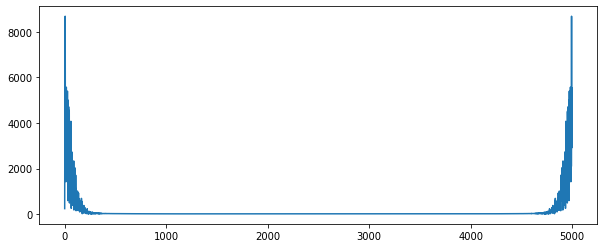

In [ ]:
# FFT of target time-series
sp = np.fft.fft(X)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(abs(sp))
plt.show()

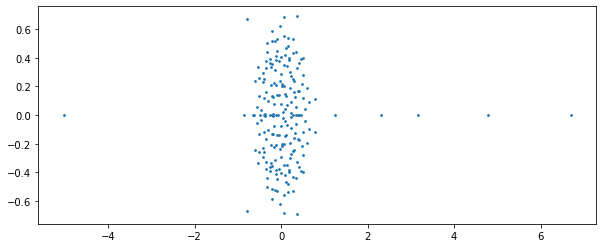

In [ ]:
def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

realW_bptt, imagW_bptt = extract_eigen_values(net.rnn.h2h.weight.detach().numpy())

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.scatter(realW_bptt, imagW_bptt, s=3)
plt.show()

# Supplementary Material

## Train the Recurrent Neural Network (RNN) via Scheduled-Sampling

During inference, the model totally depends on itself where we provide both the inputs from previous output. If the model outputs a bad output at a certain step, it in turn affects the whole sequence ahead. This problem is known as *Exposure Bias Problem*.

[Scheduled Sampling](#ref1) is a method proposed to mitigate the bias where in the model randomly chooses from where to sample during Training. That is whether to provide the ground truth as an input to next time step or to provide the output produced in the previous time step as both the inputs as it is supposed to be in the inference time.

In [ ]:
enable_ss = False

In [ ]:
if enable_ss:
    # Init RNN model
    hidden_dim = 200
    net_ss = RNNNet(1, hidden_dim, 1)

    optimizer = torch.optim.Adam(net_ss.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()

    # Number of iterations treated as burn-in
    burn_in_period = 100

    for epoch in range(2000):
            
        # Reset State and Burn-in
        net_ss(X_train_step_ss[:,0:burn_in_period,:])

        # Set teacher_forcing_ratio i.e probability 
        net_ss.teacher_forcing_ratio = 0.5

        # Gradient descent after each epoch
        optimizer.zero_grad()
        input = X_train_step_ss[:,burn_in_period:,:]
        pred, _ = net_ss(input)

        loss = loss_func(pred[q-1,:,0], Y_train[burn_in_period:])
        loss.backward()
        optimizer.step()

        if epoch%20==0:
            print(epoch, loss.data.item())

In [ ]:
if enable_ss:
    
    # Reset State and Burn-in
    net_ss(X_train_step[:,0:burn_in_period,:])

    # Predict time-series via true targets
    pred, _ = net_ss(X_train_step[:,burn_in_period:,:])

    # Compute loss
    error = loss_func(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
    print(error)

    # Plot predictions
    plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), normalize_data, "Predict time-series via true targets")

In [ ]:
if enable_ss:

    # Reset State and Burn-in
    net_ss(X_train_step[:,0:burn_in_period,:])

    # Forecast time-series via one-step ahead predictions
    data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
    one_step = one_step_ahead(net_ss, data, X_train_step[:,burn_in_period:,:].shape[1])
    one_step = np.asarray(one_step)

    # Compute loss
    error = loss_func(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
    print(error)

    # Plot predictions
    plot_time_series(X[burn_in_period+q:], one_step, "Forecast time-series via one-step ahead predictions")